In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import torch 
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
ticker = 'NVDA' 
df = yf.download(ticker, '2020-01-01')
print(df.head())

C:\Users\Prest\AppData\Local\Temp\ipykernel_18652\4246696244.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          NVDA      NVDA      NVDA      NVDA       NVDA
Date                                                         
2020-01-02  5.971411  5.971411  5.892011  5.942538  237536000
2020-01-03  5.875831  5.919638  5.826797  5.851688  205384000
2020-01-06  5.900474  5.905701  5.756360  5.782494  262636000
2020-01-07  5.971907  6.017705  5.883796  5.928847  314856000
2020-01-08  5.983108  6.024425  5.927603  5.967676  277108000


<Axes: xlabel='Date'>

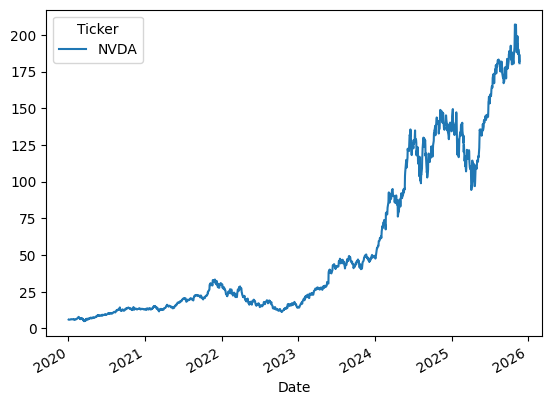

In [8]:
df.Close.plot()

In [10]:
scalar = StandardScaler()

df['Close']=scalar.fit_transform(df['Close'])
df.Close

Ticker,NVDA
Date,
2020-01-02,-0.903950
2020-01-03,-0.905702
2020-01-06,-0.905250
2020-01-07,-0.903941
2020-01-08,-0.903736
...,...
2025-11-14,2.470578
2025-11-17,2.405176
2025-11-18,2.309179


In [12]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

data

array([[[-0.90395048],
        [-0.9057015 ],
        [-0.90525005],
        ...,
        [-0.89119189],
        [-0.88907153],
        [-0.88987407]],

       [[-0.9057015 ],
        [-0.90525005],
        [-0.90394139],
        ...,
        [-0.88907153],
        [-0.88987407],
        [-0.88120571]],

       [[-0.90525005],
        [-0.90394139],
        [-0.90373619],
        ...,
        [-0.88987407],
        [-0.88120571],
        [-0.87811409]],

       ...,

       [[ 2.37659637],
        [ 2.45115914],
        [ 2.51454667],
        ...,
        [ 2.40993901],
        [ 2.47057836],
        [ 2.4051759 ]],

       [[ 2.45115914],
        [ 2.51454667],
        [ 2.34215485],
        ...,
        [ 2.47057836],
        [ 2.4051759 ],
        [ 2.30917869]],

       [[ 2.51454667],
        [ 2.34215485],
        [ 2.43668642],
        ...,
        [ 2.4051759 ],
        [ 2.30917869],
        [ 2.40371026]]])

In [19]:
train_size=int(0.8*len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)

X_test = torch.from_numpy(data[:train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[:train_size:, -1, :]).type(torch.Tensor).to(device)


In [20]:
class PredictionModel(nn.Module):
    
    def __init__(self,input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        
        self.num_layers= num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [21]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
num_epochs = 200

for i in range(num_epochs):
    Y_train_pred = model(X_train)
    
    loss= criterion(Y_train_pred, Y_train)
    
    if i % 25 ==0:
        print(i, loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
       
        

0 tensor(0.3781, grad_fn=<MseLossBackward0>)
25 tensor(0.0052, grad_fn=<MseLossBackward0>)
50 tensor(0.0023, grad_fn=<MseLossBackward0>)
75 tensor(0.0017, grad_fn=<MseLossBackward0>)
100 tensor(0.0015, grad_fn=<MseLossBackward0>)
125 tensor(0.0014, grad_fn=<MseLossBackward0>)
150 tensor(0.0012, grad_fn=<MseLossBackward0>)
175 tensor(0.0012, grad_fn=<MseLossBackward0>)


In [24]:
model.eval()

Y_test_pred = model(X_test)

Y_train_pred = scalar.inverse_transform(Y_train_pred.detach().cpu().numpy())
Y_train = scalar.inverse_transform(Y_train.detach().cpu().numpy())
Y_test_pred = scalar.inverse_transform(Y_test_pred.detach().cpu().numpy())
Y_test = scalar.inverse_transform(Y_test.detach().cpu().numpy())

In [25]:
train_rmse = root_mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
test_rsme = root_mean_squared_error(Y_test[:, 0], Y_test_pred[:,0])

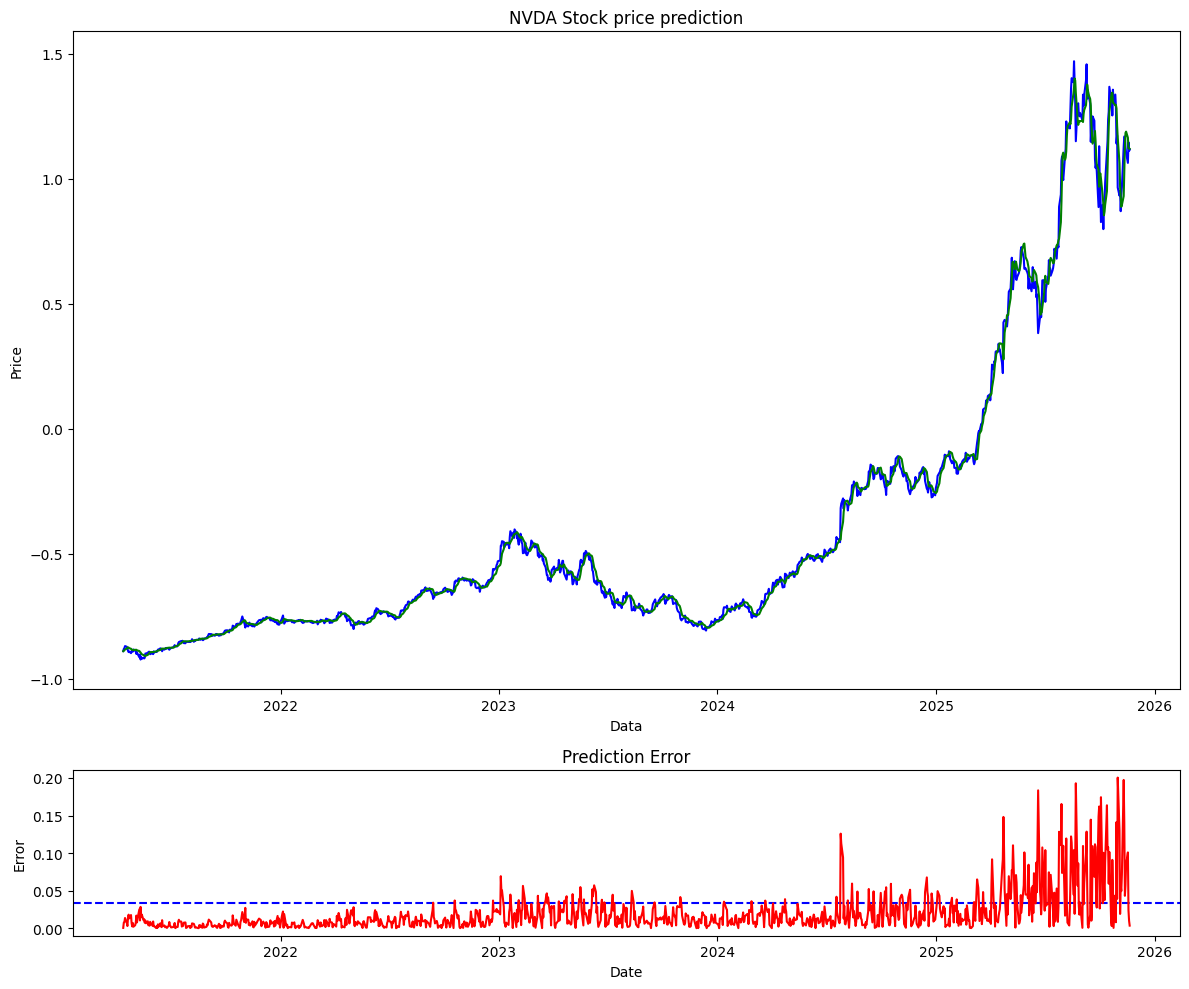

In [32]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test):].index, Y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(Y_test):].index, Y_test_pred, color = 'green', label = 'Predicted Price')

plt.title(f"{ticker} Stock price prediction")
plt.xlabel("Data")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rsme, color = 'blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(Y_test):].index, abs(Y_test - Y_test_pred), 'r', label = 'Predicted Error')
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

0.03336293622851372